In [9]:
import numpy as np
from numpy.linalg import inv
from ott.geometry.costs import SqEuclidean

import matplotlib.pyplot as plt

In [10]:
np.random.seed(5)

num_a = 10
num_b = 20

num_iters = 50
num_blocked_pairs = 12

In [11]:
# locs
a = np.arange(num_a)
b = np.arange(num_b) * 0.5

# weights 
u = np.random.random(a.shape[0])
u_0 = u.copy()

v = np.random.random(b.shape[0]) * 0.5
v_0 = v.copy()

# cost fn
C = SqEuclidean().all_pairs(a.reshape(-1,1), b.reshape(-1,1))

In [12]:
print(np.sum(u), np.sum(v))

5.087058166832671 4.322850114859159


In [13]:
gamma_0 = 1.99 # closeness to reference plan / regularisation
gamma = 10.0 # enforcement of column constraints
gamma_r = 2.0 # enforcement of row constraints

Text(0.5, 1.0, 'K with 12 blocked cells')

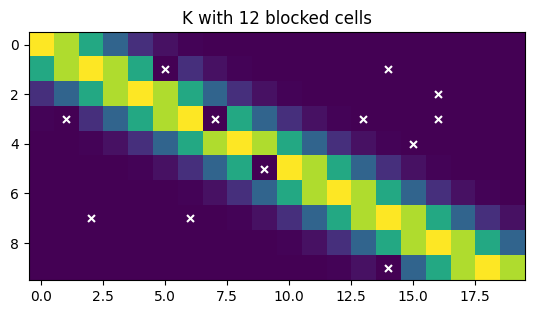

In [14]:
# kernel
K = np.pow(np.e, -C / gamma_0)

# choose which index pairs to block
l_idxs_x = np.random.choice(np.arange(a.shape[0]), num_blocked_pairs)
l_idxs_y = np.random.choice(np.arange(b.shape[0]), num_blocked_pairs)
K[l_idxs_x, l_idxs_y] = 0

rows_to_relax = np.random.choice([0,1], size=u.size, p=[0.5,0.5])
row_exponent = gamma_r/(1+gamma_r) * rows_to_relax
row_exponent[rows_to_relax == 0] = 1.0

plt.imshow(K)
plt.scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')
plt.title(f'K with {num_blocked_pairs} blocked cells')

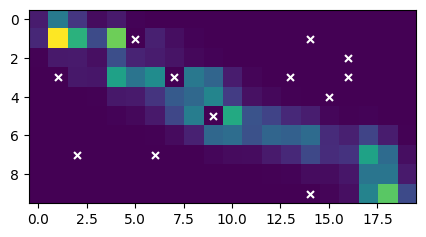

In [15]:
T = K.copy()
T_old = T.copy()
differ = np.zeros((num_iters,))

fig, ax = plt.subplots(figsize=(5,4))

for i in range(num_iters):
    D1 = inv(np.diag(np.sum(T, axis=1))) * u
    D1 = np.pow(D1, row_exponent)
    T = D1.dot(T)
    u_full = np.diag(np.pow(np.diag(D1), -1/gamma_r)).dot(u)
    u[rows_to_relax == 1] = u_full[rows_to_relax == 1]

    D2 = inv(np.diag(np.sum(T, axis=0))) * v
    D2 = np.pow(D2, gamma/(1+gamma))
    T = T.dot(D2)
    v = np.diag(np.pow(np.diag(D2), -1/gamma)).dot(v)

    differ[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()

ax.imshow(T)
ax.scatter(l_idxs_y, l_idxs_x, marker='x', s=25, c='white')

Text(0.5, 1.0, 'Convergence')

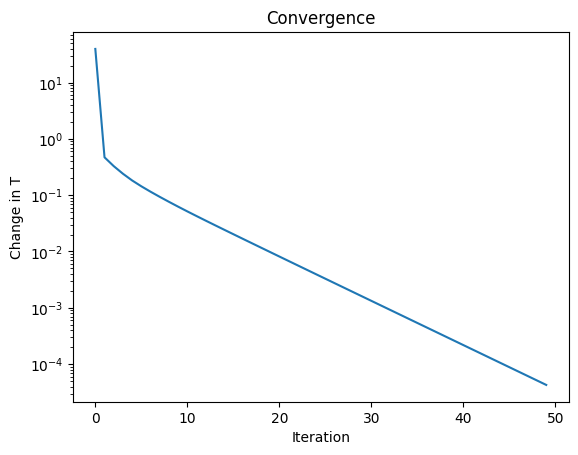

In [8]:
fig, ax = plt.subplots()

ax.plot(differ)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')
ax.set_title('Convergence')

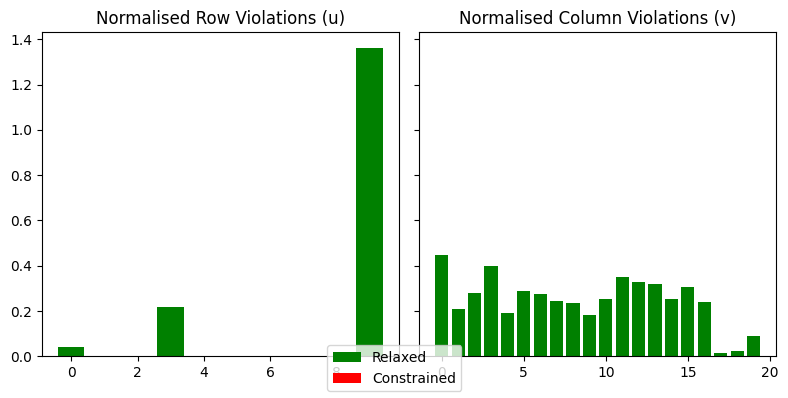

In [9]:
from matplotlib.patches import Patch

# fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(8,4))
fig, (ax_r, ax_c) = plt.subplots(1,2, figsize=(8,4), sharey='row')

def binary_to_colour(arr):
    colours = np.array(arr, dtype=str)
    colours[arr == 1] = 'green'
    colours[arr == 0] = 'red'
    return colours

ax_r.bar(x=np.arange(num_a), height=np.abs(u_0 - np.sum(T, axis=1)) / u_0, color=binary_to_colour(rows_to_relax))
ax_r.set_title('Normalised Row Violations (u)')
fig.legend(labels=['Relaxed', 'Constrained'], handles=[Patch(facecolor='green'), Patch(facecolor='red')], loc='outside lower center')

ax_c.bar(x=np.arange(num_b), height=np.abs(v_0 - np.sum(T, axis=0)) / v_0, color='green')
ax_c.set_title('Normalised Column Violations (v)')

fig.tight_layout()

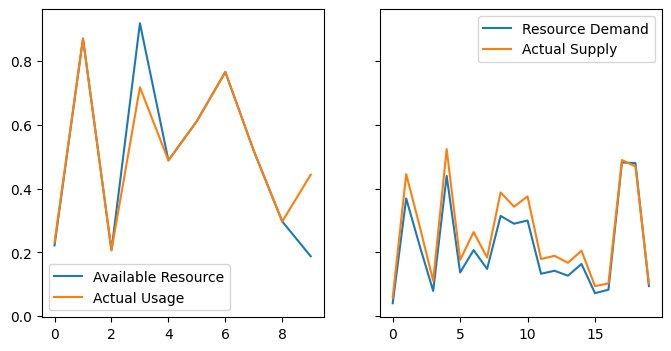

In [10]:
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey='row')

axs[0].plot(u_0, label='Available Resource')
axs[0].plot(np.sum(T, axis=1), label='Actual Usage')
axs[0].legend()

axs[1].plot(v_0, label='Resource Demand')
axs[1].plot(np.sum(T, axis=0), label='Actual Supply')
axs[1].legend()

In [11]:
rows_to_relax

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [12]:
np.sum(np.multiply(T, C))

np.float64(5.764497074087714)